In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tools as sm_tools

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('adult.csv')
X = df.drop('income', axis=1)
y = df['income'].map({'<=50K': 0, '>50K': 1})

In [3]:
num_feat = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
cat_feat = ['workclass', 'marital.status', 'occupation', 'race', 'sex', 'native.country']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feat),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_feat)
    ], 
    sparse_threshold=0.0
)

<Axes: >

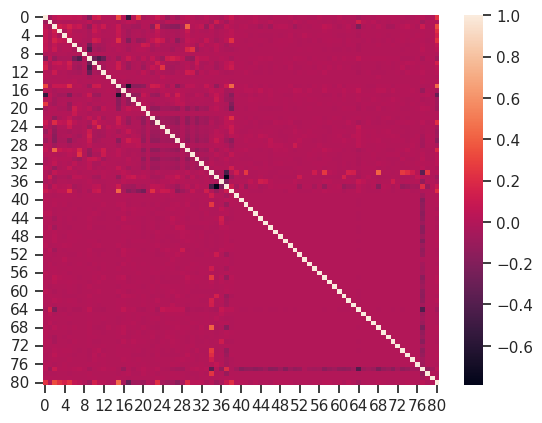

In [4]:
import seaborn as sns
sns.set_theme(style='ticks')

X_prep = preprocessor.fit_transform(X)
m = np.concat([X_prep, y.to_numpy()[:, None]], axis=1)

sns.heatmap(np.corrcoef(m.T))

In [5]:
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = train_test_split(X_prep, y, random_state=42)
variances = X_train.var(axis=0)
non_zero_variance_cols_idx = np.where(variances > 0)[0]

X_train = X_train[:, non_zero_variance_cols_idx]
X_test = X_test[:, non_zero_variance_cols_idx]
selected_feats = set()
remaining_feats = set(range(X_train.shape[1]))
previous_score = float('inf')

while remaining_feats:
    min_score, min_feat = float('inf'), None
    X_selected = sm_tools.add_constant(X_train[:, list(selected_feats)])
    
    feats_to_remove = set()
    
    for feat in remaining_feats:
        X_feat = np.expand_dims(X_train[:, feat], axis=-1)
        X_new = np.append(X_selected, X_feat, axis=-1)
        
        try:
            new_model = sm.Logit(y_train, X_new).fit(disp=0)
            if new_model.bic < min_score:
                min_score, min_feat = new_model.bic, feat
        except np.linalg.LinAlgError:
            print(f"Removing feature {feat}")
            feats_to_remove.add(feat)
            
    remaining_feats -= feats_to_remove
    
    if min_score >= previous_score:
        break
    
    selected_feats.add(min_feat)
    remaining_feats.remove(min_feat)
    previous_score = min_score
    
    print(f"Selected feats: {len(selected_feats)}, remaining feats: {len(remaining_feats)}, current score: {previous_score:.2f}")
    
print(f"Selected features: {selected_feats} (n={len(selected_feats)}, score={previous_score})")

Selected feats: 1, remaining feats: 79, current score: 21806.42
Selected feats: 2, remaining feats: 78, current score: 18943.28
Selected feats: 3, remaining feats: 77, current score: 17402.24
Removing feature 13
Selected feats: 4, remaining feats: 75, current score: 17083.53
Selected feats: 5, remaining feats: 74, current score: 16789.89
Selected feats: 6, remaining feats: 73, current score: 16526.46
Removing feature 76
Selected feats: 7, remaining feats: 71, current score: 16356.09
Selected feats: 8, remaining feats: 70, current score: 16251.95
Selected feats: 9, remaining feats: 69, current score: 16173.89
Selected feats: 10, remaining feats: 68, current score: 16145.53
Selected feats: 11, remaining feats: 67, current score: 16118.33
Selected feats: 12, remaining feats: 66, current score: 16094.17
Selected feats: 13, remaining feats: 65, current score: 16075.15
Selected feats: 14, remaining feats: 64, current score: 16053.16
Selected feats: 15, remaining feats: 63, current score: 160

In [7]:
from sklearn.metrics import roc_auc_score

X_train_selected = sm_tools.add_constant(X_train[:, list(selected_feats)])
model = sm.Logit(y_train, X_train_selected).fit(disp=0, maxiter=100)

X_test_selected = sm_tools.add_constant(X_test[:, list(selected_feats)])
y_pred = model.predict(X_test_selected) > 0.5

roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc:.3f}")

ROC AUC: 0.756
